# Chapter 4 Exercises

In [140]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from scipy import stats
from scipy.special import expit as logistic

from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

np.random.seed(123)

## Exercise 1
***

*Re-run the first model using the petal length and then petal width variables. What are the main differences in the results? How wide or narrow is the 95% HPD interval in each case?*

In [40]:
iris = pd.read_csv('../code/data/iris.csv')
df = iris.query("species in ['setosa', 'versicolor']")

group = 'species'
idx, group_names = df[group].factorize()

In [41]:
features = df.drop(group, axis=1).columns.to_list()

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [82]:
traces = []

for feature in features:
    with pm.Model() as iris_single_feat_model:

        ss = StandardScaler().fit(df[feature].values.reshape(-1, 1))
        x_transformed = ss.transform(df[feature].values.reshape(-1, 1)).squeeze(-1)

    #     x = pm.Data('x', df[feature].values)
        x = pm.Data('x', x_transformed)
        y = pm.Data('y', idx)

        # priors
        α = pm.Normal('α', sigma=10)
        β = pm.Normal('β', sigma=10)

        # log-odds
        π = pm.Deterministic('π', α + β*x)

        # logistic transformation
        ß = pm.Deterministic('ß', pm.math.sigmoid(π))

        # liklihood
        pm.Bernoulli('liklihood', p=ß, observed=y)

        # sample posterior
        trace = pm.sample(progressbar=False)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for som

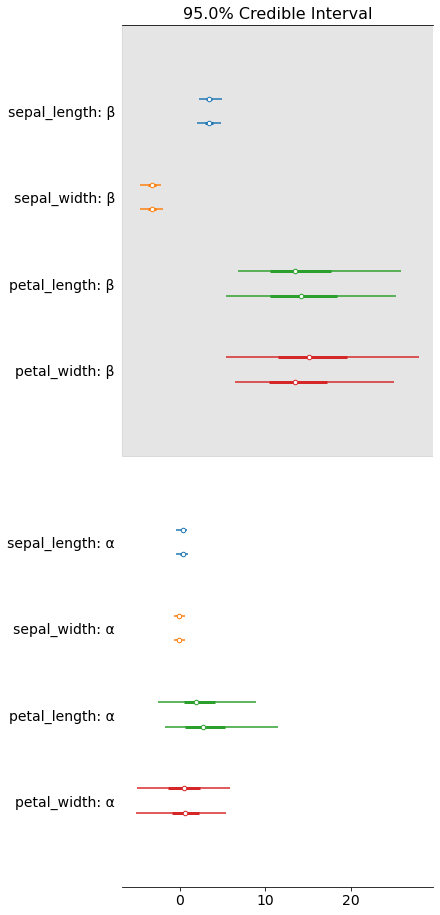

In [83]:
var_names=['β', 'α']
az.plot_forest(traces, var_names=var_names, model_names=features, credible_interval=0.95);

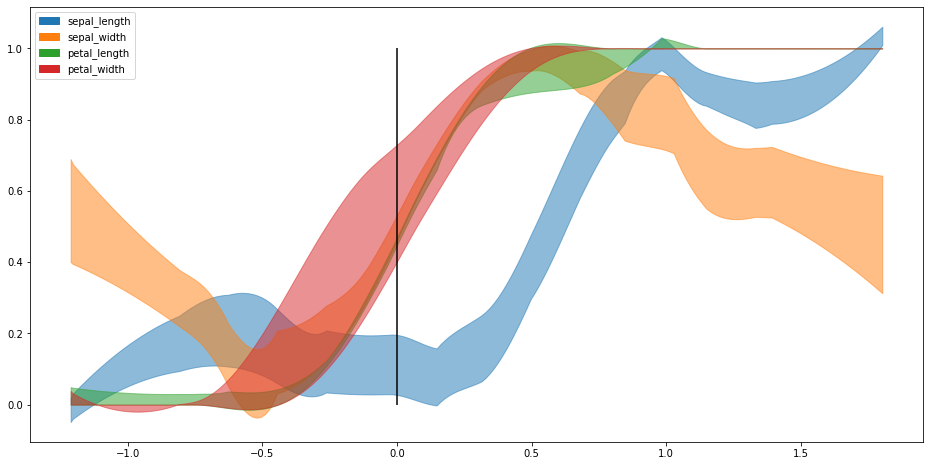

In [139]:
handles = []
_, ax = plt.subplots(figsize=(16, 8))
for i, (trace, feature) in enumerate(zip(traces, features)):
    az.plot_hpd(x=x.eval(), y=trace['ß'], credible_interval=0.95, color=f'C{i}', show=False, ax=ax);
    handles.append(mpatches.Patch(color=f'C{i}', label=feature))

plt.vlines(x=0., ymin=0., ymax=1.0)
plt.legend(handles=handles);

In [84]:
# az.plot_hpd(x=x.eval(), y=trace['π']);

### Book Answer

In [2]:
iris = pd.read_csv('../code/data/iris.csv')
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes

varnames = ['α', 'β', 'bd']

In [5]:
traces = []

for feature in ["sepal_length", "petal_width", "petal_length"]:

    x_n = feature
    x_0 = df[x_n].values
    x_c = x_0 - x_0.mean()

    with pm.Model() as model_0:
        α = pm.Normal('α', mu=0, sd=10)
        β = pm.Normal('β', mu=0, sd=10)

        μ = α + pm.math.dot(x_c, β)    
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -α/β)

        yl = pm.Bernoulli('yl', p=θ, observed=y_0)

        trace_0 = pm.sample(1000)
        traces.append(trace_0)
        
        print("Feature {} summary".format(feature))
        print(az.summary(trace_0, varnames, credible_interval=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1034.14draws/s]


Feature sepal_length summary
     mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α   0.304  0.343    -0.335      0.999      0.009    0.007    1368.0  1060.0   
β   5.420  1.075     3.648      7.805      0.031    0.023    1177.0  1103.0   
bd -0.055  0.062    -0.175      0.063      0.002    0.001    1557.0  1291.0   

    ess_bulk  ess_tail  r_hat  
α     1388.0    1107.0    1.0  
β     1242.0    1080.0    1.0  
bd    1546.0    1532.0    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 2 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 898.67draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Feature petal_width summary
      mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α    0.719  1.914    -2.813      4.692      0.090    0.074     451.0   332.0   
β   18.147  5.646     8.382     28.878      0.262    0.187     465.0   457.0   
bd  -0.040  0.095    -0.220      0.128      0.004    0.003     703.0   590.0   

    ess_bulk  ess_tail  r_hat  
α      501.0     499.0   1.01  
β      487.0     645.0   1.00  
bd     688.0     801.0   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 32 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 719.29draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Feature petal_length summary
      mean     sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α    3.500  4.252    -3.149     12.765      0.217    0.153     385.0   385.0   
β   13.441  5.690     3.322     23.800      0.306    0.221     345.0   331.0   
bd  -0.268  0.292    -0.816      0.228      0.013    0.010     468.0   468.0   

    ess_bulk  ess_tail  r_hat  
α      406.0     551.0   1.01  
β      364.0     510.0   1.01  
bd     477.0     797.0   1.01  


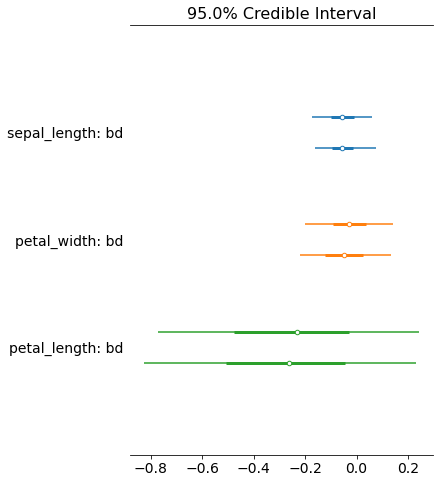

In [8]:
az.plot_forest(traces, var_names=['bd'], model_names=["sepal_length", "petal_width", "petal_length"], credible_interval=0.95);

From the results, we can see that the `bd` variable's HPD is the smallest with sepal length, and increases with petal_width and petal_length.

## Exercise 2
***

*Repeat exercise 1, this time using a Student's t-distribution as a weakly informative prior. Try different values of $\nu$.*

In [25]:
for nu in [1, 10, 30]:

    x_0 = df["petal_length"].values
    x_c = x_0 - x_0.mean()

    with pm.Model() as model_0:
        # Priors have been changed
        α = pm.StudentT('α', nu=nu, mu=0, sd=10)
        β = pm.StudentT('β', nu=nu, mu=0, sd=10)


        μ = α + pm.math.dot(x_c, β)    
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -α/β)

        yl = pm.Bernoulli('yl', p=θ, observed=y_0)

        trace_0 = pm.sample(1000)
        
        print(f"Feature {feature} nu {nu} summary")
        print(az.summary(trace_0, varnames, credible_interval=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 442.69draws/s]
There were 660 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5723934984887481, but should be close to 0.8. Try to increase the number of tuning steps.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Feature petal_length nu 1 summary
      mean      sd  mc error  hpd 2.5%  hpd 97.5%  eff_n  r_hat
α     4.95   13.41      1.15    -10.62      27.76  126.0   1.00
β   137.73  450.93     81.03      3.59     598.05   41.0   1.03
bd   -0.17    0.25      0.04     -0.73       0.17   49.0   1.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 879.48draws/s] 
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Feature petal_length nu 10 summary
     mean    sd  mc error  hpd 2.5%  hpd 97.5%  eff_n  r_hat
α    4.03  4.56      0.14     -3.52      13.52  434.0    1.0
β   14.50  6.94      0.40      3.71      27.74  334.0    1.0
bd  -0.29  0.28      0.01     -0.83       0.18  543.0    1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1032.88draws/s]
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Feature petal_length nu 30 summary
     mean    sd  mc error  hpd 2.5%  hpd 97.5%  eff_n  r_hat
α    3.94  4.30      0.20     -2.79      13.68  327.0   1.00
β   14.01  5.98      0.38      4.00      25.55  369.0   1.01
bd  -0.28  0.28      0.01     -0.83       0.19  329.0   1.00


## Exercise 3
***

*Go back to the first example, the logistic regression for classifying setosa or versicolor given sepal length. Try to solve the same problem using a simple linear regression model, as we saw in chapter 3. How useful is linear regression compared to logistic regression? Can the result be interpreted as a probability?*

*Tip: check whether the values of $y$ are restricted to the interval [0,1].*

In [26]:
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    sd = pm.HalfNormal("sd", sd=1)

    μ = α + pm.math.dot(x_c, β)

    yl = pm.Normal('yl', mu=μ, sd=sd, observed=y_0)
    
    trace_linear = pm.sample(1000)
    
    posterior_predictive_linear = pm.sample_posterior_predictive(trace_linear)
    print(az.summary(trace_linear, credible_interval=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, β, α]
100%|██████████| 2000/2000 [00:01<00:00, 1088.84it/s]


    mean    sd  mc error  hpd 2.5%  hpd 97.5%   eff_n  r_hat
α   0.50  0.04       0.0      0.43       0.57  3075.0    1.0
β   0.57  0.05       0.0      0.46       0.67  3047.0    1.0
sd  0.35  0.02       0.0      0.30       0.40  2519.0    1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28401ba8>],
      dtype=object)

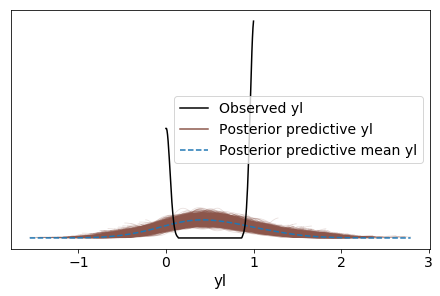

In [27]:
data = az.from_pymc3(trace=trace_linear, posterior_predictive=posterior_predictive_linear)
az.plot_ppc(data);

From the posterior predictive checks, this model is not very useful. We are trying to estimate the probability of a species given sepal_length, but a number of the posterior predictive check values are below 0 and above 1. As such, the result cannot be interpreted as a probability.

## Exercise 4
***

*In the example from the "Interpreting the coefficients of a logistic regression" section, we changed `sepal_length` by 1 unit. Using figure 4.6, corroborate that the value of `log_odds_versicolor_i` corresponds to the value of `probability_versicolor_i`. Do the same for `log_odds_versicolor_f` and `probability_versicolor_f`. Just by noting that `log_odds_versicolor_f` - `log_odds_versicolor_i` is negative, what can you say about the probability? Use figure 4.6 to help you. Is this result clear to you from the definition of log-odds?*

In [28]:
df = iris.query("species == ('setosa', 'versicolor')") 
y_1 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_1 = df[x_n].values

In [29]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:17<00:00, 287.70draws/s]
The acceptance probability does not match the target. It is 0.8848631965762076, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
varnames = ['α', 'β'] 
summary = az.summary(trace_1, var_names=varnames)
summary

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,-9.24,4.59,0.11,-17.84,-0.47,1504.0,1.0
β[0],4.71,0.88,0.03,3.03,6.34,1370.0,1.0
β[1],-5.22,1.01,0.02,-7.25,-3.56,1567.0,1.0


In [31]:
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (summary['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)

log_odds_versicolor_f = (summary['mean'] * [1, x_1, x_2+1]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f - probability_versicolor_i

(-5.219999999999999, -0.02387657278569843)

The value of -5.22 is consistent with the summary and our "hand check". A log odds value of -5.22 means that as $x_2$ increases by one unit, the probability that the species is versicolor decreases. Or, equivalently, as sepal width increases, the probability that the flower is versicolor decreases.

We can verify this with a quick plot:

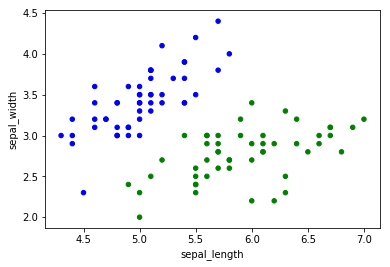

In [32]:
colors = df["species"].replace({'setosa':"blue", 'versicolor':"green"})
df.plot(kind="scatter", x="sepal_length", y="sepal_width", c=colors);

We see that, as sepal width increases from 3 to 4, we get further away from the green dots, reducing the probability that the flower we're seeing is of the versicolor species.

## Question 5
***

*Use the same example from the previous exercise. For `model_1`, check how much the log-odds change when increasing `sepal_length` from 5.5 to 6.5 (spoiler: it should be 4.66). How much does the probability change? How does this increase compared to when we increase `sepal_length` from 4.5 to 5.5?*

In [36]:
# Values for sepal length are directly added in the log_odds_line
x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

for i in (0,1):
    log_odds_versicolor_i = (summary['mean'] * [1, x_1 + i, x_2]).sum()
    probability_versicolor_i = logistic(log_odds_versicolor_i)


    log_odds_versicolor_f = (summary['mean'] * [1, x_1 + i + 1, x_2]).sum()
    probability_versicolor_f = logistic(log_odds_versicolor_f)

    print(f"""sepal_length_i {x_1 + i}, sepal_length_f {x_1 + i + 1}
    Log Odds Change {log_odds_versicolor_f - log_odds_versicolor_i}
    Probability Change {probability_versicolor_f - probability_versicolor_i}
    """)

sepal_length_i 4.5, sepal_length_f 5.5
    Log Odds Change 4.709999999999999
    Probability Change 0.7080309252764029
    
sepal_length_i 5.5, sepal_length_f 6.5
    Log Odds Change 4.710000000000001
    Probability Change 0.26467417655124303
    


From the calculation above we see that while the log-odds change stays constant, as it should in linear regression, the probability change is not as large from 5.5 to 6.5 as it is from 4.5 to 5.5. Looking at the graphic this intuitively makes sense as well. When sepal length is at 4.5, the chance that the species is versicolor is very small. When sepal length jumps to 5.5, this probability gets a lot bigger. This means that subsequently going from 5.5 to 6.5 still increases the probability of versicolor, but not as much - because, well, at 5.5 there is already a good chance that the species we're seeing is versicolor.

## Exercise 6
***

*In the example for dealing with unbalanced data, change `df = df[45:]` to `df = df[22:78]`. This will keep roughly the same number of data points, but now the classes will be balanced. Compare the new result with the previous ones. Which one is more similar to the example using the complete dataset?*

In [2]:
iris = pd.read_csv('../code/data/iris.csv')

df = iris.query("species == ('setosa', 'versicolor')") 
df = df[22:78]

y_3 = pd.Categorical(df['species']).codes 
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values

varnames = ['α', 'β'] 

In [3]:
with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
     
    μ = α + pm.math.dot(x_3, β) 
    θ = 1 / (1 + pm.math.exp(-μ)) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0]) 
     
    yl = pm.Bernoulli('yl', p=θ, observed=y_3) 
 
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 320.29draws/s]
The acceptance probability does not match the target. It is 0.8827315277894231, but should be close to 0.8. Try to increase the number of tuning steps.


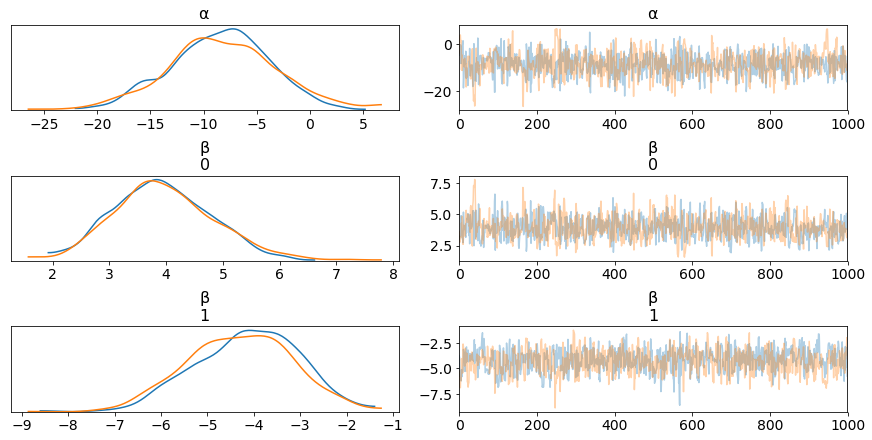

In [4]:
az.plot_trace(trace_3, varnames);

/Users/canyon/.miniconda3/envs/bap/lib/python3.6/site-packages/scipy/signal/_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)


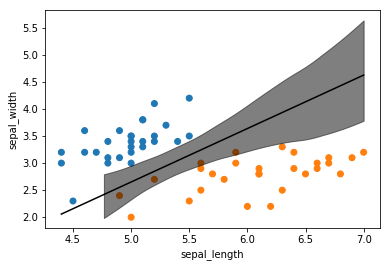

In [5]:
idx = np.argsort(x_3[:,0]) 
bd = trace_3['bd'].mean(0)[idx]

plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3]) 
plt.plot(x_3[:,0][idx], bd, color='k')

az.plot_hpd(x_3[:,0], trace_3['bd'], color='k')

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1]);

The decision boundary in this plot looks more like the unfiltered dataset as the blue data points are largely not contained in the boundary decision's 95% HPD. This indicates that the balanced model, even with less data points, is better able to distinguish between classes.

## Exercise 7
***

*Suppose instead of a softmax regression we use a simple linear model by coding `setosa = 0`, `versicolor = 1` and `virginica = 2`. Under the simple linear regression model, what will happen if we switch the coding? Will we get the same or different results?*

Lets run the model to have data points for a discussion:

In [6]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sd=5, shape=3)
    β = pm.Normal('β', mu=0, sd=5, shape=(4, 3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:39<00:00, 90.06draws/s]


In [14]:
print(trace_s['μ'].shape)
print(trace_s['μ'][:,0,0].mean())

(4000, 150, 3)
20.50240089583297


In [15]:
data_pred = trace_s['μ'].mean(0)
data_pred[:5]

array([[ 20.5024009 ,   6.48490714, -27.0838455 ],
       [ 17.39770936,   7.02248623, -24.56869099],
       [ 19.88486309,   6.2033202 , -26.23990539],
       [ 18.74471434,   5.99731255, -24.90962857],
       [ 21.56848135,   6.03376081, -27.70047043]])

#### Conceptual Understanding
Note the shape of the trace. The dimensions should read as follows: we have 4000 estimations of the 3 softmax class values for each of the 150 rows in the dataset.

#### Discussion
If we changed the softmax model to a linear regression model a couple things would change. First, the interpretation of the final output would be different. A softmax prediction estimates the probability of each class, whereas a linear regression would just provide one number as an estimate for the class. The other problem is that a linear regression would output continous values across all real numbers, and how to define when one class starts and another ends is unclear.

## Exercise 8
***

*Compare the likelihood of the logistic model versus the likelihood of the LDA model. Use the `sample_posterior_predictive` function to generate predicted data and compare the types of data you get for both cases. Be sure you understand the difference between the types of data the model predicts.*

In [16]:
iris = pd.read_csv('../code/data/iris.csv')
df = iris.query("species == ('setosa', 'versicolor')") 
y_3 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'
x_3 = df[x_n].values

Logistic Regression model (Discriminative)

In [23]:
with pm.Model() as logistic_model:
    α = pm.Normal("α", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=10)
    μ =  α + pm.math.dot(x_3, β)
    
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α / β )
    
    y1= pm.Bernoulli("y1", p=θ, observed=y_3)
    
    trace_logistic = pm.sample(2000)
    ppc_logistic = pm.sample_posterior_predictive(trace_logistic)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 385.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1000/1000 [00:00<00:00, 1586.40it/s]


Linear Discriminant Analysis (Discriminative)

In [24]:
with pm.Model() as lda_model:
    σ = pm.HalfNormal("σ", sd=10)
    μ = pm.Normal("μ", mu=0, sd=10, shape=2)
    
    setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_3[:50])
    versicolor = pm.Normal("versicolor", mu=μ[1], sd=σ, observed=x_3[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    
    trace_lda = pm.sample(1000)
    ppc_lda = pm.sample_posterior_predictive(trace_lda)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1168.67draws/s]
The acceptance probability does not match the target. It is 0.8892659742708484, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:02<00:00, 692.00it/s]


The likelihood of the logisitic regression model is as follows

$$ y \text{~} Bernoulli(\theta) $$

and the likelihood of the Linear Discriminative Analysis are

\begin{eqnarray}
Versicolor_{sepal\_length} \text{~} Normal(\mu_0, \sigma) \newline
Setosa_{sepal\_length} \text{~} Normal(\mu_1, \sigma)
\end{eqnarray}

In the logistic regression we are not estimating the properties of the sepal length. We are merely fitting parameters of the inverse link function. In the LDA model we are estimating the sepal length distributions directly.

In [30]:
ppc_logistic["y1"][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [32]:
ppc_lda["setosa"][0]

array([5.59852617, 5.09568788, 5.26277595, 4.67319903, 4.970315  ,
       4.53590922, 4.08561261, 5.88398851, 4.70309481, 5.01470091,
       4.86725988, 4.77155467, 5.38988434, 6.06846195, 4.13818591,
       4.93774811, 4.96063805, 4.62652669, 4.95666654, 5.01235388,
       4.54895677, 4.24667044, 5.08459178, 4.47643989, 4.26908685,
       4.03809189, 5.0624234 , 5.21945325, 5.01683427, 4.70436585,
       5.14984516, 5.13216414, 5.14483366, 4.70856442, 4.15395632,
       4.42284433, 3.91473064, 4.88724366, 4.69020283, 4.88200706,
       4.98517253, 5.754367  , 4.80215121, 5.51413712, 4.25565248,
       4.62582676, 5.05025521, 5.54609099, 4.9940747 , 5.13240562])

When comparing the posterior predictive, it can be seen that the logistic model is binary, estimating either 0 or 1, while the LDA model has real numbers that generally look like sepal lengths. This follows our understandings of the models: the logistic regression makes predictions as to which class a particular sepal length belongs to, whereas the LDA model makes predictions about the sepal lengths directly.

## Exercise 9
***

*Using the fish data, extend the `ZIP_reg` model to include the persons variable as part of a linear model. Include this variable to model the number of extra zeros. You should get a model that includes two linear models: one connecting the number of children and the presence/absence of a camper to the Poisson rate (as in the example we saw), and another connecting the number of persons to the $\psi$ variable. For the second case, you will need a logistic inverse link!*

In [1]:
fish_data = pd.read_csv('../code/data/fish.csv')

with pm.Model() as ZIP_reg:
    # ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
    
    α_person = pm.Normal('α_person', 0, 10)
    β_person = pm.Normal('β_person', 0, 10)
    ψ = pm.math.sigmoid(α_person + β_person * fish_data['persons'])
    
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
    
    trace_ZIP_reg = pm.sample(1000)
    
az.plot_trace(trace_ZIP_reg);

NameError: name 'pd' is not defined

## Exercise 10
***

*Use the data for the robust logistic example to feed a non-robust logistic regression model and to check that the outliers actually affected the results. You may want to add or remove outliers to better understand the effect of the estimation on a logistic regression and the robustness of the model introduced in this chapter.*

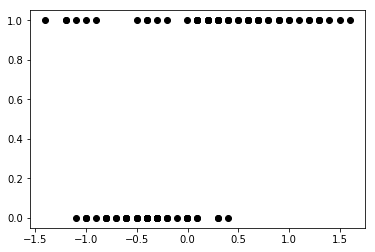

In [38]:
iris = sns.load_dataset("iris") 
df = iris.query("species == ('setosa', 'versicolor')") 

y_0 = pd.Categorical(df['species']).codes 
x_n = 'sepal_length'  
x_0 = df[x_n].values 
y_0 = np.concatenate((y_0, np.ones(6, dtype=int))) 
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 
x_c = x_0 - x_0.mean() 

plt.plot(x_c, y_0, 'o', color='k');

Let's take the robust logistic regression from the chapter and make it non robust:

In [49]:
with pm.Model() as non_rlg:
    α = pm.Normal("α", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=10)
    μ = α + β * x_c
    
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))
    bd = pm.Deterministic("bd", -α/β)
    
    # Short Circuit Robust regression
    # π = pm.Beta("π", 1, 1)
    # p = π *.5 + (1-π)*θ
    p = θ
    
    y = pm.Bernoulli("y", p=p, observed=y_0)
    
    trace_rlg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [π, β, α]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1023.28draws/s]


In [51]:
varnames = ['α', 'β', 'bd']
az.summary(trace_rlg, varnames)

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α,0.23,0.24,0.01,-0.24,0.67,2338.0,1.0
β,2.38,0.48,0.01,1.55,3.36,2242.0,1.0
bd,-0.10,0.10,0.00,-0.30,0.10,2516.0,1.0


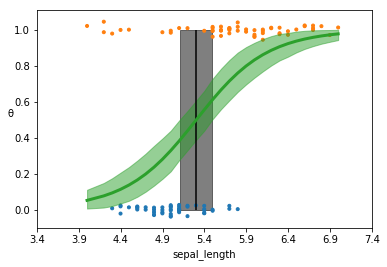

In [50]:
theta = trace_rlg['θ'].mean(axis=0)
idx = np.argsort(x_c)

plt.vlines(trace_rlg['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02), marker='.', color=[f'C{x}' for x in y_0])
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
theta_hpd = az.hpd(trace_rlg['θ'])[idx]
plt.fill_between(x_c[idx], theta_hpd[:,0], theta_hpd[:,1], color='C2', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)

# use original scale for xticks
locs, _ = plt.xticks() 
plt.xticks(locs, np.round(locs + x_0.mean(), 1))
plt.savefig('B11197_04_13.png', dpi=300);

Compare this plot to figure 4.13. Note that the HPD for the decision boundary is wider, reflecting the additional uncertainty. This is also reflected in the slope which is more gradual. This is reflected both in the plot, but also the beta parameter (15.77 for robust model versus 2.38 for the non-robust model).

## Exercise 11
***

*Read and run the following notebooks from PyMC3's documentation:*

- [GLM: Linear regression](https://docs.pymc.io/notebooks/GLM-linear.html)
- [GLM: Robust Linear Regression](https://docs.pymc.io/notebooks/GLM-robust.html)
- [GLM: Hierarchical Linear Regression](https://docs.pymc.io/notebooks/GLM-hierarchical.html)